## Loading all the needed things

In [1]:
!git clone https://github.com/JordanFoss/STAT3007_Project.git
%cd STAT3007_Project/

Cloning into 'STAT3007_Project'...
remote: Enumerating objects: 4045, done.
remote: Counting objects: 100% (323/323), done.
remote: Compressing objects: 100% (263/263), done.
remote: Total 4045 (delta 145), reused 197 (delta 58), pack-reused 3722
Receiving objects: 100% (4045/4045), 682.57 MiB | 30.94 MiB/s, done.
Resolving deltas: 100% (730/730), done.
Checking out files: 100% (2861/2861), done.
/content/STAT3007_Project


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install colorednoise

  Created wheel for colorednoise: filename=colorednoise-1.1.1-cp37-none-any.whl size=3958 sha256=bcea7f3c5be51df57ea685148b91923da4e50d0aeb5d19d1a8fd9ede05ed8e4e
  Stored in directory: /root/.cache/pip/wheels/84/be/f3/3e7e1c80ebab3f6f0dbd3e34e787b902d2280d66706485fef4
Successfully built colorednoise


In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
import scipy
import numpy as np
import librosa
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.autograd import Variable
import pandas as pd
import glob
from librosa import display

from IPython.display import Audio

# load our own python files
from pre_process import *
from data_loading import *
from CNN_Model import *

## Load Clean Data

In [16]:
#Load the clean audio data
import scipy.io
mat = scipy.io.loadmat('/content/STAT3007_Project/jet.mat')
jet = mat['ans']
X,y = load_samples('/content/STAT3007_Project', padding = True, truncating = True, normal = True, duration = 2, Noisfy=False)
X = np.array(X)
# (batch_size, channels, freq, time)
X = X.reshape(X.shape[0],1,X.shape[1],X.shape[2])

In [17]:
RGB_images = Make_All_RGB(X, jet)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [18]:
RGB_images = torch.tensor(RGB_images)

In [19]:
X = torch.tensor(X)

y = torch.tensor(y)

## Load All Noisy Data

In [46]:
#Import all the noisy data
noisy_data_train = np.load('/content/drive/MyDrive/STAT3007 project/train_test_split_snr40/noisy_train_snr40.npy')
noisy_data_test = np.load('/content/drive/MyDrive/STAT3007 project/train_test_split_snr40/noisy_test_snr40.npy')
noisy_targets_train = np.load('/content/drive/MyDrive/STAT3007 project/train_test_split_snr40/target_train_snr40.npy')
noisy_targets_test = np.load('/content/drive/MyDrive/STAT3007 project/train_test_split_snr40/target_test_snr40.npy')

noisy_data_train = noisy_data_train.reshape(noisy_data_train.shape[0],1,noisy_data_train.shape[1],noisy_data_train.shape[2])
noisy_data_test = noisy_data_test.reshape(noisy_data_test.shape[0],1,noisy_data_test.shape[1],noisy_data_test.shape[2])

noisy_data_train = torch.tensor(noisy_data_train)
noisy_data_test = torch.tensor(noisy_data_test)

#noisy_data = torch.tensor(noisy_data).reshape(noisy_data.shape[0],1,noisy_data.shape[1],noisy_data.shape[2])
noisy_targets_train = torch.tensor(noisy_targets_train)
noisy_targets_test = torch.tensor(noisy_targets_test)

# Training
Now we attempt to train on some datasets and see how it performs.
* Loss function: softmax
* learning rate = 0.01

In [7]:
def train_model(data_train, 
                data_test, 
                net, loss, 
                nepoch , 
                lr = 0.01, 
                batch_size = -1, 
                momentum = 0,
                use_cuda = False, 
                print_output = True, 
                optimiser = 'SGD'):

  # setting up arrays for recording
  test_acc = []
  avg_acc = []

  test_loss = []
  avg_loss = []
  # appropriate data type for CPU or GPU
  device = None
  if use_cuda and torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    device = torch.device("cuda")
    net = net.to(device)
  else:
    dtype = torch.FloatTensor

  if optimiser == 'SGD':
    optimizer = optim.SGD(net.parameters(), lr = lr, momentum = momentum)
  else:
    optimizer = optim.Adam(net.parameters(), lr = lr, momentum = momentum)
  data_train = data_train.change_type(dtype)
  data_test = data_test.change_type(dtype)

  X_test,y_test = data_test.get_data()

  y_test = y_test.type(torch.LongTensor)
  if device != None:
    y_test = y_test.type(torch.cuda.LongTensor)

  data_loader = DataLoader(data_train, batch_size = batch_size, shuffle = True)

  for epoch in range(nepoch):
    batch_acc = []
    batch_loss = []
    for X_batch, y_batch in data_loader:
      

      y_batch = y_batch.type(torch.LongTensor)
      if use_cuda and device != None:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_batch = y_batch.type(torch.cuda.LongTensor)

        

      optimizer.zero_grad()


      pred = net(X_batch)
      Rn = loss(pred, y_batch)
      accur = accuracy(pred,y_batch)

      batch_acc.append(accur)
      batch_loss.append(Rn.to(torch.device('cpu')).detach().numpy())

      Rn.backward()
      optimizer.step()


    avg_batch_loss = np.mean(batch_loss)
    avg_batch_acc = np.mean(batch_acc)
    avg_acc.append(avg_batch_acc)
    avg_loss.append(avg_batch_loss)

    pred = net(X_test)
    Rn = loss(pred, y_test)
    accur = accuracy(pred,y_test)
    test_acc.append(accur)
    test_loss.append(Rn.to(torch.device('cpu')).detach().numpy())


    if print_output:
      print('epoch:', epoch)
      print('loss:',Rn.item())
      print('------------')
    

  print('final loss:', Rn.item())

  return net, avg_loss, avg_acc, test_loss, test_acc


In [47]:
#Clean
wrapper_train = DatasetWrapper(noisy_data_train, noisy_targets_train)
wrapper_test = DatasetWrapper(noisy_data_test, noisy_targets_test)
data_train, data_test = wrapper_train, wrapper_test

#data_train, data_test = load_sets(RGB_images,y)[0]

#Noisy Samples
#thing, data_test = load_sets(X_noisy,y_noisy)[0]

#Noisy
#data_train, thing = load_sets(noisy_data,noisy_targets)[0]

accuracies_learningrate = []
loss = nn.CrossEntropyLoss()
nepoch = 50
batch_size = 10
torch.manual_seed(69)
thing = []
#CNN = ConvNet_RGB(contain_linear = True, filter_num = 8, channels = 3)
#initial_state = CNN.state_dict()
#trained_net, avg_loss, avg_acc, test_loss, test_acc = train_model(data_train,data_test, CNN, loss, nepoch = nepoch,lr = 0.001, batch_size = batch_size, use_cuda = True,print_output = False, momentum=0.4)
X_test, y_test = data_test.get_data()
X_test = X_test.type(torch.FloatTensor).to(torch.device('cpu'))
trained_net = trained_net.to(torch.device('cpu'))
y_pred = trained_net(X_test)
accuracy_score = accuracy(y_pred,y_test)
print('accuracy:' + str(accuracy_score))
thing.append(accuracy_score)

accuracy:0.43953487277030945


In [28]:
torch.save(trained_net.state_dict(), '/content/drive/MyDrive/STAT3007 project/Noisy_RGB_CNN_parameters')

In [48]:
import sklearn
labels = ['Calm', 'Happy', 'Sad', 'Angry', 'Suprised']
confusion = sklearn.metrics.confusion_matrix(y_test, torch.argmax(y_pred, dim=1))
thing = sklearn.metrics.ConfusionMatrixDisplay(confusion, display_labels=labels)
thing.plot(values_format='.5g')

In [21]:
results = np.array([avg_loss, test_loss, avg_acc, test_acc])
results.shape

(4, 50)

In [24]:
np.save('/content/drive/MyDrive/STAT3007 project/CNN_Models_Results/CNN_RGB_Clean.npy', results)

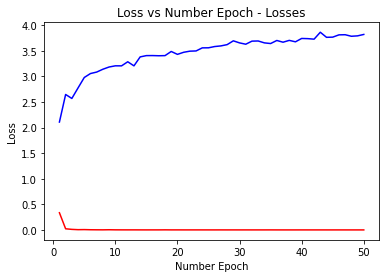

In [26]:
plt.plot([x for x in range(1,nepoch+1)], avg_loss, 'r', [x for x in range(1,nepoch+1)], test_loss, 'b')
plt.xlabel("Number Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Number Epoch - Losses")
plt.show()

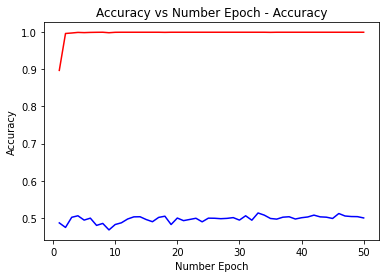

In [27]:
plt.plot([x for x in range(1,nepoch+1)], avg_acc, 'r', [x for x in range(1,nepoch+1)], test_acc, 'b')
plt.xlabel("Number Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number Epoch - Accuracy")
plt.show()

# Testing

In [31]:
Baseline_CNN_Result = np.load('/content/drive/MyDrive/STAT3007 project/CNN_Models_Results/Baseline_CNN_Noisy.npy')
RGB_CNN_Result = np.load('/content/drive/MyDrive/STAT3007 project/CNN_Models_Results/CNN_RGB_Noisy.npy')
CNN_LSTM_Result = np.load('/content/drive/MyDrive/STAT3007 project/CNN_Models_Results/CNN_LSTM_Noisy.npy')

In [32]:
results = {'Baseline_CNN_Result' : Baseline_CNN_Result, 'RGB_CNN_Result' : RGB_CNN_Result, 'CNN_LSTM_Result' : CNN_LSTM_Result}

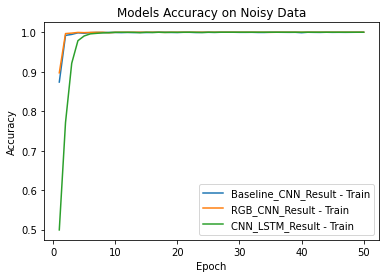

In [37]:
foo = ['Train', 'Test', 'Train', 'Test']
for result in ['Baseline_CNN_Result', 'RGB_CNN_Result', 'CNN_LSTM_Result']:
  plt.plot([x for x in range(1,51)], results[result][2], label=result + ' - ' + foo[2])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Models Accuracy on Noisy Data')
plt.legend()
plt.show()